In [6]:
using JuMP, Gurobi, CombinatorialPricing

In [2]:
# Import a problem from a file
file = "./problems/knapsack/expset-2/kpp2-n30-01.json"
prob = read(file, KnapsackPricing)

KnapsackPricing with 30 items (15 tolled)

In [6]:
# Create a value function model
model_vf = value_function_model(prob)

Set parameter OutputFlag to value 1
Set parameter Threads to value 0


A JuMP Model
├ solver: Gurobi
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 62
├ num_constraints: 123
│ ├ AffExpr in MOI.EqualTo{Float64}: 1
│ ├ AffExpr in MOI.GreaterThan{Float64}: 15
│ ├ AffExpr in MOI.LessThan{Float64}: 32
│ ├ VariableRef in MOI.GreaterThan{Float64}: 30
│ ├ VariableRef in MOI.LessThan{Float64}: 15
│ └ VariableRef in MOI.ZeroOne: 30
└ Names registered in the model
  └ :callback_calls, :callback_time, :f, :follower, :g, :heur_provider, :knapsack, :primalobj, :prob, :sdtol, :strongdual, :subproblem_time, :subproblem_times, :t, :toll_bounds, :tx, :vf_x, :x

In [7]:
# Solve the model
optimize!(model_vf)

Set parameter Threads to value 0
Set parameter OutputFlag to value 1
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (armlinux64 - "Ubuntu 22.04.5 LTS")

CPU model: ARM64
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
LazyConstraints  1

Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Optimize a model with 48 rows, 62 columns and 183 nonzeros
Model fingerprint: 0x511fdeb9
Variable types: 32 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+00, 1e+02]
  RHS range        [1e-04, 7e+02]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 47 rows, 61 columns, 181 nonzeros
Variable types: 31 continuous, 30 integer (30 binary)

Root relaxation: objective 1.062886e+03, 72 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current 

In [17]:
model_f = follower_model(prob)

follower_obj = set_toll!(model_f, prob, value.(model_vf[:t]))

optimize!(model_f)

Set parameter OutputFlag to value 1
Set parameter Threads to value 0
Set parameter Threads to value 0
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (armlinux64 - "Ubuntu 22.04.5 LTS")

CPU model: ARM64
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Optimize a model with 1 rows, 30 columns and 30 nonzeros
Model fingerprint: 0xa6603a45
Variable types: 0 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [2e+00, 1e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 7e+02]
Found heuristic solution: objective -778.3329667
Presolve removed 1 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: -82

In [43]:
inp = Dict(model_f[:x][i] => value(model_vf[:x][i]) for i in 1:num_items(prob))
value(i -> inp[i], follower_obj), objective_value(model_f)

(-822.9995999999992, -822.9997000000001)

Value-function model is sound.

## Selection Diagram

In [386]:
numpairs = 5

# Sample some solutions
sampler = MaximalKnapsackSampler(prob)
samples = rand(sampler, numpairs)

# Extract random pairs from the samples
pairs = random_pair.(samples)

# Create a selection diagram
sd = sdgraph_from_pairs(prob, pairs)

SDGraph{KnapsackPricing} with 3 layers, 16 nodes, and 19 arcs

In [387]:
l = length(sd.layers) - 1
for u in sd.layers[l]
    empty_arc = SDArc((l, u), sink_node(sd), DPAction())
    push!(sd.arcs, empty_arc)
end

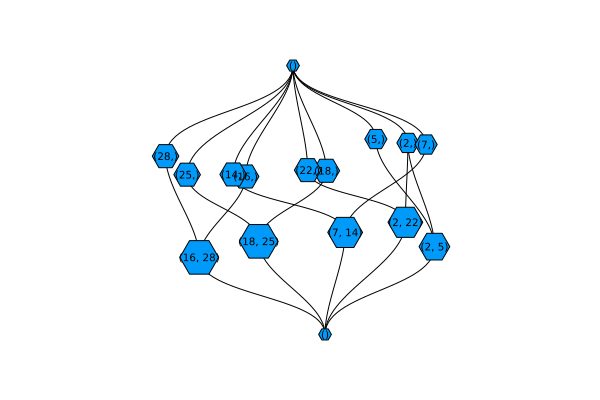

In [461]:
using Plots, Graphs

function plot_selection_diagram(sd)
    incidence = zeros(Int, nv(sd), nv(sd))

    V = collect(vertices(sd))

    for a in edges(sd)
        i = findfirst(v -> v == a.src, V)
        j = findfirst(v -> v == a.dst, V)
        incidence[i, j] = 1
    end

    graphplot(incidence, names=[v[2] for v in V], curves=true, method=:tree)
end

plot_selection_diagram(sd)

### Solve

In [462]:
# Create a model from the SD
# model_sd = sdgraph_model(sd)  # This is the model with the callback already

# Create baseline SD model
model_sd = base_model(prob)
CombinatorialPricing.add_sdgraph_dual!(model_sd, sd)

# equivalent to the first iteration, i.e., solves the relaxation
optimize!(model_sd)

Set parameter OutputFlag to value 1
Set parameter Threads to value 0
Set parameter Threads to value 0
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (armlinux64 - "Ubuntu 22.04.5 LTS")

CPU model: ARM64
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Optimize a model with 75 rows, 78 columns and 255 nonzeros
Model fingerprint: 0x575491b7
Variable types: 48 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+00, 1e+02]
  RHS range        [1e-04, 8e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 31 rows and 19 columns
Presolve time: 0.00s
Presolved: 44 rows, 59 columns, 182 nonzeros
Found heuristic solution: objective 344.5001000
Variable types: 29 continuous, 30 integer (30 binary)

Root relaxation: objective 4.3124

In [463]:
# candidate solution
x_hat = value.(model_sd[:x])
t_hat = value.(model_sd[:t])
;

### Best Response

In [464]:
model_f = follower_model(prob)

follower_obj = set_toll!(model_f, prob, value.(t_hat))

inp = Dict(model_f[:x][i] => value(x_hat[i]) for i in 1:num_items(prob))
follower_obj_hat = value(i -> inp[i], follower_obj)

Set parameter OutputFlag to value 1
Set parameter Threads to value 0


-631.9999

In [465]:
optimize!(model_f)

Set parameter Threads to value 0
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (armlinux64 - "Ubuntu 22.04.5 LTS")

CPU model: ARM64
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Optimize a model with 1 rows, 30 columns and 30 nonzeros
Model fingerprint: 0x30b8c630
Variable types: 0 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [2e+00, 1e+02]
  Objective range  [8e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 7e+02]
Found heuristic solution: objective -838.0000000
Presolve removed 1 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.17 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: -886 -838 
No other solutions better than -886

Optimal solution found (

In [466]:
# follower's best response
x_br = value.(model_f[:x])

sum(.!(x_hat .≈ x_br))

12

In [467]:
x_set = CombinatorialPricing.convert_x_to_set(x_br)

arc_best_response = SDArc(source_node(sd), sink_node(sd), x_set)

added = false
for l in 2:-1:1
    layer = sd.layers[l]
    for s in layer
        (s.selected ⊆ x_set) || continue
        arc_label = setdiff(x_set, s.selected)
        arc_best_response = SDArc((l, s), sink_node(sd), arc_label)
        added = true
        break
    end
    added && break
end

# push!(sd.arcs, arc_best_response)

println(arc_best_response)

DPArc (2, (16, 28)) => (3, ()) (1, 3, 4, 6, 8, 10, 12, 15, 20, 21, 22, 24, 29)


### Separation Problem

In [468]:
# state matrix
S = zeros(Int, num_items(prob), nv(sd))

for (j, v) in enumerate(collect(vertices(sd)))
    for i in v[2].selected
        S[i,j] = 1
    end
end

In [469]:
# dual variables vector
y = zeros(nv(sd))

for (j, v) in enumerate(vertices(sd))
    y[j] = -value(model_sd[:y][v])
end

In [470]:
model_sep = Model(Gurobi.Optimizer)

@variable(model_sep, u[1:nv(sd)], Bin)
@variable(model_sep, l[1:num_items(prob)], Bin)

@constraint(model_sep, prob.weights' * (S * u .+ l) <= prob.capacity)
@constraint(model_sep, S * u .+ l .<= 1)
@constraint(model_sep, sum(u) == 1)
@constraint(model_sep, u[end] == 0)

ct = base_costs(prob) .+ CombinatorialPricing.expand_t(t_hat, prob)
@objective(model_sep, Min, y' * u + ct' * l)

optimize!(model_sep)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2562957
Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (armlinux64 - "Ubuntu 22.04.5 LTS")

CPU model: ARM64
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Optimize a model with 33 rows, 46 columns and 110 nonzeros
Model fingerprint: 0xd2f5590b
Variable types: 0 continuous, 46 integer (46 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [8e+00, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Found heuristic solution: objective -206.0000000
Presolve removed 25 rows and 16 columns
Presolve time: 0.00s
Presolved: 8 rows, 30 columns, 52 nonzeros
Variable types: 0 continuous, 30 integer (30 binary)

Root relaxation: objective -8.682236e+02

In [471]:
u_star = collect(vertices(sd))[findfirst(round.(Bool, value.(u)))]
arc_label = Set(findall(round.(Bool, value.(l))))

arc_separation = SDArc(u_star, sink_node(sd), arc_label)

DPArc (1, (5,)) => (3, ()) (1, 3, 4, 6, 8, 12, 15, 16, 18, 22, 24, 28)

In [472]:
arc_best_response

DPArc (2, (16, 28)) => (3, ()) (1, 3, 4, 6, 8, 10, 12, 15, 20, 21, 22, 24, 29)

In [473]:
findall(round.(Bool, x_br))

15-element Vector{Int64}:
  1
  3
  4
  6
  8
 10
 12
 15
 16
 20
 21
 22
 24
 28
 29

In [474]:
arc_separation.src[2].selected ∪ arc_separation.action

BitSet with 13 elements:
  1
  3
  4
  5
  6
  8
  12
  15
  16
  18
  22
  24
  28

In [475]:
function get_x_index(var)
    m = match(r"\[(\d+)\]", name(var))

    return parse(Int, m.captures[1])
end

# inp = Dict(model_f[:x][i] => value(x_hat[i]) for i in 1:num_items(prob))
# follower_obj_hat = value(x_i -> inp[x_i], follower_obj)

value(x_i -> x_br[get_x_index(x_i)], objective_function(model_f))

-886.0

In [476]:
value(x_i -> get_x_index(x_i) in arc_separation.src[2].selected ∪ arc_separation.action, objective_function(model_f))

-884.9999

In [477]:
# best response violation
-value(model_sd[:y][arc_best_response.src]) + sum(ct[i] for i in arc_best_response.action)

-254.0

In [478]:
# separation violation
-value(model_sd[:y][arc_separation.src]) + sum(ct[i] for i in arc_separation.action)

-864.9999

In [286]:
for u in vertices(sd)
    print(u[2].selected)
    print(" -> ")

    θ = -value(model_sd[:y][u])

    γ = 0

    for i in findall(convert.(Bool, x_br))
        if ~(i in u[2].selected)
            γ += ct[i]
        end
    end

    println(θ, " + ", γ, " = ", θ + γ)
end

BitSet([]) -> 108.0 + -800.5 = -692.5
BitSet([1]) -> 30.0 + -800.5 = -770.5
BitSet([29]) -> -0.0 + -770.5 = -770.5
BitSet([7]) -> 88.0 + -800.5 = -712.5
BitSet([13]) -> -0.0 + -712.5 = -712.5
BitSet([5]) -> 96.0 + -800.5 = -704.5
BitSet([12]) -> 12.0 + -704.5 = -692.5
BitSet([14]) -> 12.0 + -775.5 = -763.5
BitSet([20]) -> -0.0 + -792.5 = -792.5
BitSet([1, 29]) -> 0.0 + -770.5 = -770.5
BitSet([7, 13]) -> 0.0 + -712.5 = -712.5
BitSet([5, 12]) -> 0.0 + -704.5 = -704.5
BitSet([5, 14]) -> 0.0 + -775.5 = -775.5
BitSet([7, 20]) -> 0.0 + -792.5 = -792.5
BitSet([]) -> -0.0 + -800.5 = -800.5


### Add the arcs

In [480]:
sd_sep = SDGraph(prob, copy(sd.layers), copy(sd.arcs))
sd_br = SDGraph(prob, copy(sd.layers), copy(sd.arcs))

push!(sd_br.arcs, arc_best_response)
push!(sd_sep.arcs, arc_separation)

model_sd_br = base_model(prob)
CombinatorialPricing.add_sdgraph_dual!(model_sd_br, sd_br)

model_sd_sep = base_model(prob)
CombinatorialPricing.add_sdgraph_dual!(model_sd_sep, sd_sep)
;

Set parameter OutputFlag to value 1
Set parameter Threads to value 0
Set parameter OutputFlag to value 1
Set parameter Threads to value 0


In [481]:
optimize!(model_sd_br)

Set parameter Threads to value 0
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (armlinux64 - "Ubuntu 22.04.5 LTS")

CPU model: ARM64
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Optimize a model with 76 rows, 78 columns and 263 nonzeros
Model fingerprint: 0xb915e557
Variable types: 48 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+00, 1e+02]
  RHS range        [1e-04, 8e+02]
Presolve removed 25 rows and 16 columns
Presolve time: 0.00s
Presolved: 51 rows, 62 columns, 204 nonzeros
Variable types: 32 continuous, 30 integer (30 binary)
Found heuristic solution: objective -0.0000000

Root relaxation: objective 4.194474e+02, 56 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      

In [482]:
optimize!(model_sd_sep)

Set parameter Threads to value 0
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (armlinux64 - "Ubuntu 22.04.5 LTS")

CPU model: ARM64
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2562957 - for non-commercial use only - registered to br___@umontreal.ca
Optimize a model with 76 rows, 78 columns and 264 nonzeros
Model fingerprint: 0x137e1af3
Variable types: 48 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+00, 1e+02]
  RHS range        [1e-04, 9e+02]
Found heuristic solution: objective 167.5002000
Presolve removed 25 rows and 16 columns
Presolve time: 0.00s
Presolved: 51 rows, 62 columns, 205 nonzeros
Variable types: 32 continuous, 30 integer (30 binary)

Root relaxation: objective 4.295183e+02, 43 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds     

In [483]:
value.(model_sd_sep[:x]) ≈ value.(model_sd_br[:x])

false

In [484]:
value.(model_sd_sep[:t]).data ≈ value.(model_sd_br[:t]).data

false

In [485]:
value.(model_sd_br[:t])

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, [1, 4, 7, 8, 9, 11, 15, 17, 18, 19, 22, 23, 24, 26, 30]
And data, a 15-element Vector{Float64}:
 123.0
  16.5
  38.0000500000001
  41.5000500000001
  73.5
 108.0
  55.5
  81.0
   0.0
  39.0
   0.0
   0.0
  15.0
  87.5000500000001
   3.0

In [486]:
value.(model_sd_sep[:t])

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, [1, 4, 7, 8, 9, 11, 15, 17, 18, 19, 22, 23, 24, 26, 30]
And data, a 15-element Vector{Float64}:
 108.99990000000003
  16.5
  40.5
  31.500099999999975
  73.5
  81.50009999999997
   0.0
  81.0
 130.5
  39.0
   0.0
   0.0
  15.0
   0.0
   3.0

In [487]:
findall(convert.(Bool, value.(model_sd_br[:x])))

12-element Vector{Int64}:
  1
  3
  4
  6
  7
  8
 11
 16
 18
 22
 23
 26

In [488]:
findall(convert.(Bool, value.(model_sd_sep[:x])))

15-element Vector{Int64}:
  1
  4
  6
  7
  8
 11
 15
 16
 18
 20
 22
 23
 24
 26
 30

### Update original SD

In [460]:
push!(sd.arcs, arc_best_response)

26-element Vector{SDArc}:
 DPArc (0, ()) => (1, (18,)) (18,)
 DPArc (0, ()) => (1, (25,)) (25,)
 DPArc (0, ()) => (1, (16,)) (16,)
 DPArc (0, ()) => (1, (28,)) (28,)
 DPArc (0, ()) => (1, (2,)) (2,)
 DPArc (0, ()) => (1, (5,)) (5,)
 DPArc (0, ()) => (1, (7,)) (7,)
 DPArc (0, ()) => (1, (14,)) (14,)
 DPArc (0, ()) => (1, (22,)) (22,)
 DPArc (1, (18,)) => (2, (18, 25)) (25,)
 ⋮
 DPArc (1, (14,)) => (2, (7, 14)) (7,)
 DPArc (1, (22,)) => (2, (2, 22)) (2,)
 DPArc (2, (18, 25)) => (3, ()) ()
 DPArc (2, (16, 28)) => (3, ()) ()
 DPArc (2, (2, 5)) => (3, ()) ()
 DPArc (2, (7, 14)) => (3, ()) ()
 DPArc (2, (2, 22)) => (3, ()) ()
 DPArc (2, (16, 28)) => (3, ()) (2, 3, 5, 6, 7, 9, 12, 14, 17, 20, 21, 27, 29, 30)
 DPArc (2, (16, 28)) => (3, ()) (1, 3, 4, 6, 11, 18, 19, 20, 21, 23, 24, 26)